<img style="float: left;" src="EP_Logo.png" alt="UoE" width="300px"/>
<img style="float: right;" src="UoE_Logo.png" alt="UoE" width="300px"/>
<img style="float: center;" src="urban_rural_scape.png" alt="urban" width="1100px"/>

# Modelling emissions from road traffic
<img style="float: right;" src="car-exhaust.png" alt="smoky car" width="240px"/></p>
 
Jupyter notebook for ECSC09005 Environmental Pollution  
author: jbm *for* Session 2020-21  [version 0.13, latest 19:30, 2 Dec 2020]
## Background
The Gaussian Plume model we discussed in lectures is good for point and area sources. To model traffic flowing along a road we adapt the gaussian plume model by effectively replicating point sources along the roadway and running individual gaussian plume models at each of these points. This is known as a line source model. In this exercise, we will use a line source model called *RLine* from  the US Environmnental Protection Agency. This model has been well used for many years and is used for all sorts of regulatory purposes. You can read more about RLine at the US EPA's web site - https://www.cmascenter.org/r-line/ 

What I want you to get out of RLine is an appreciation for how wind speed, atmospheric stability and wind direction dictate local air quality.

## Imports
Let's start by importing some libraries to the environment:
- *matplotlib inline* for creating inline plots
- *pandas* to order and sort data in a convenient Table-like format
- *numpy* for numerical routines
- *matplotlib* for plotting data
- *scipy* for interploation routines
- *tqdm* for timing progress bar 
- *subprocess* so we can run the model written in FORTRAN
- *ipywidgets* for interactivity
- *defins* for python code that just takes up space in the main notebook

In [9]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import griddata
import matplotlib.gridspec as gridspec
import sys
import math
import tqdm as tqdm
import subprocess
import os
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets
from ipywidgets import HBox, Label
#from rlplots.py import *

## Step 1: Get familiar with the model

In [10]:
# Delete any old data before running the model again
## delete only if file exists ##
if os.path.exists('Output_Example_Numerical.csv'):
    os.remove('Output_Example_Numerical.csv')
#ret = subprocess.call(["./RLINEv1_2.ifort.x"],shell=True)

In [11]:
ret = subprocess.call(["./RLINEv1_2_gfortran_mac.exe"],shell=True)
# WAIT for the program to run - once you see the 'Run complete' message
# it's OK to click the next cell and move on. This may take up to 10 seconds.
print("Run complete")

Run complete


In [12]:
sites = []
max = min = 0
gs = gridspec.GridSpec(4, 4)
gs.update(left=0.10, right=0.95, hspace=0.05)
hourly_stab = ['stable','weakly stable','weakly convective','convective']

infilename = 'Output_Example_Numerical.csv'
infilename2 = 'Met_Example.csv'   
# use Pandas to read in emissions data
dfe=pd.read_csv("Output_Example_Numerical.csv", header=10, skipinitialspace=True)
# Split into hourly dataframes for graphing
# https://stackoverflow.com/questions/54046707/pandas-split-one-dataframe-into-multiple-dataframes
for h in dfe['Hour'].unique():
    temp = 'dfe_{}'.format(h)    
    vars()[temp] = dfe[dfe['Hour']==h]
dfe_1.head(5)

,Year,Julian_Day,Hour,X-Coordinate,Y-Coordinate,Z-Coordinate,C_G1,C_G2,Unnamed: 8
0,12,264,1,10.0,10.0,1.5,2043070.0,2042370.0,NaN
1,12,264,1,10.0,20.0,1.5,2043230.0,1824570.0,NaN
2,12,264,1,10.0,30.0,1.5,2043180.0,1669700.0,NaN
3,12,264,1,10.0,40.0,1.5,2043080.0,1544800.0,NaN
4,12,264,1,10.0,50.0,1.5,2043160.0,1440970.0,NaN


In [22]:
def plot_line_source(xx, yy, zz, hour):
    """Docstring"""
    # define grid
    xi = np.linspace(-100., 100., 100)
    yi = np.linspace(-100., 100., 100)
    #print(xx.shape, yy.shape, zz.shape)
    #print(len(xi), len(xx), len(zz))
    X,Y= np.meshgrid(xi,yi)
    #Z = griddata((x, y), z, (X, Y),method='nearest')
    zi = griddata((xx, yy), zz, (X, Y), method='linear')

    # plot the roadways running N-S and E-W
    ax1 = plt.subplot(gs[:, :-1])
    ax1.plot([5, 5], [-100, 100], color='k', linestyle='--', linewidth=1)
    ax1.plot([-5, -5], [-100, 100], color='k', linestyle='--', linewidth=1)
    ax1.plot([-100, 100], [-5, -5], color='k', linestyle='--', linewidth=1)
    ax1.plot([-100, 100], [5, 5], color='k', linestyle='--', linewidth=1)
    ax1.set_ylabel('distance (m)', fontsize=11)
    ax1.set_xlabel('distance (m)', fontsize=11)
    circ1 = plt.Circle((20, 20), 1.5, color='red')
    ax1.add_artist(circ1)
    circ2 = plt.Circle((20, -20), 1.5, color='green')
    ax1.add_artist(circ2)
    circ3 = plt.Circle((-20, -20), 1.5, color='blue')
    ax1.add_artist(circ3)
    circ4 = plt.Circle((-20, 20), 1.5, color='black')
    ax1.add_artist(circ4)

    # Contours etc explained here: 
    # http://matplotlib.org/examples/pylab_examples/contourf_demo.html
    levels = np.arange(min, max, (max-min)/20)
    # contour the gridded data, plotting dots at the nonuniform data points.
    ax1.contour(xi, yi, zi, levels, linewidths=0.5, colors='w')
    CS1 = ax1.contourf(xi, yi, zi, levels, cmap=plt.cm.jet, vmax=abs(zi).max(), vmin=-abs(zi).max())
    # Make a colorbar for the ContourSet returned by the contourf call.
    cbar = plt.colorbar(CS1)  # orientation = 'horizontal')
    cbar.ax.set_title('$ng m^{-3}$',fontsize=9)
    ax1.set_xlim(-100, 100)
    ax1.set_ylim(-100, 100)
    ax1.set_title('PM10 Ground-Level Concentration \n (%s)'%hourly_stab[hour-1], fontsize=11, color='blue')
    #plt.show()


def plot_met_data(datam, sites):
    """Docstring"""
    hour = datam['Hour']
    u = float(datam['u'])
    wdir = int(float(datam['dir']))
    MOLength = int(float(datam['L']))
    H = int(float(datam['Hs']))
    sbl = int(float(datam['SBL']))
    # print u,wdir,MOLength,H,sbl
    # convert wdir to radians
    wdirr = wdir * math.pi /180
    # Compute pie slices
    # from MatplotlIb web page of examples
    theta = wdirr
    radii = 8
    width = np.pi / 16
    # go clockwise as in a compass
    ax2 = plt.subplot(gs[:-1, -1], projection='polar')
    ax2.set_theta_direction(-1)
    # Make sure North points to top of page
    ax2.set_theta_offset(90*math.pi /180)
    ax2.bar(theta, radii, width=width, bottom=0.0)
    ax2.set_title('Met conditions')
    ax3 = plt.subplot(gs[-1, -1])
    ax3.set_frame_on(False)
    ax3.axes.get_xaxis().set_visible(False)
    ax3.axes.get_yaxis().set_visible(False)
    ax3.text(0.1, 1.5, r'u = %d $m s^{-1}$'%u, fontsize=9)
    ax3.text(0.1, 1.4, r'wdir = %i degrees'%wdir, fontsize=9)
    ax3.text(0.1, 1.3, r'H = %d $Wm^{-2}$'%H, fontsize=9)
    ax3.text(0.1, 1.2, r'sbl = %d m'%sbl, fontsize=9)
    ax3.text(0.1, 1.1, r'MOLength = %d m'%MOLength, fontsize=9)
    ax3.text(0.1, 1.0, r' ', fontsize=10)
    # format returns a str
    ax3.text(0.1, 0.9, r's1 = %s $ng m^{-3}$' % '{0:.2f}'.format(sites[0]), fontsize=9,color='red')
    ax3.text(0.1, 0.8, r's2 = %s $ng m^{-3}$' % '{0:.2f}'.format(sites[1]), fontsize=9,color='green')
    ax3.text(0.1, 0.7, r's3 = %s $ng m^{-3}$' % '{0:.2f}'.format(sites[2]), fontsize=9,color='blue')
    ax3.text(0.1, 0.6, r's4 = %s $ng m^{-3}$' % '{0:.2f}'.format(sites[3]), fontsize=9,color='black')
    ax3.text(0.1, 0.5, r' ', fontsize=10)
    ax3.text(0.1, 0.4, r'-------------------------- ', fontsize=9)
    ax3.text(0.1, 0.3, r'Model: RLine V1.2', fontsize=10,color='blue')
    ax3.text(0.1, 0.2, r'Emission height = 1 m', fontsize=10)
    ax3.text(0.1, 0.1, r'Roadway ---', fontsize=10)

    fig = plt.gcf()
    fig.facecolor='white'
    plt.subplots_adjust(hspace=0.5, wspace=0.2)
    # fig.set_size_inches(10, 8)
    fig.subplots_adjust(top=0.85, left=0.1, right=0.95, bottom=0.1)
    fig.savefig('rline_%d.png'%hour, dpi=100)
    #plt.show()

,Year,Month,Day,Jday,Hour,Hs,u*,w*,VPTG,CBL,...,dir,zref,T,ztemp,s1,s2,s3,s4,s5,s6
0,12,9,20,264,1,-10,0.10,0,99,-999,...,225,11.4,275.5,6.8,99,99,99,99,99,99
1,12,9,20,264,2,2,0.30,0,99,-999,...,225,11.4,278.0,6.8,99,99,99,99,99,99
2,12,9,20,264,3,150,0.25,0,99,-999,...,225,11.4,281.0,6.8,99,99,99,99,99,99
3,12,9,20,264,4,25,0.70,0,99,-999,...,225,11.4,278.0,6.8,99,99,99,99,99,99


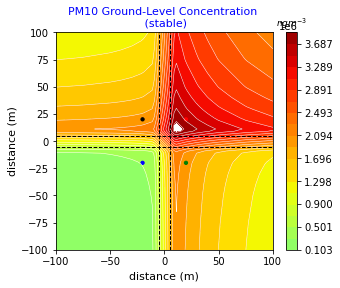

In [23]:
# extract the x, y, z-values to 1-D arrays for plotting
xx = dfe_1['X-Coordinate'].to_numpy()
yy = dfe_1['Y-Coordinate'].to_numpy()
zz = (dfe_1['C_G1']+dfe_1['C_G2']).to_numpy()
    
max = (dfe_1['C_G1']+dfe_1['C_G2']).max()
min = (dfe_1['C_G1']+dfe_1['C_G2']).min()

# get the concentration values at the 4 receptor sites
dfs1 = dfe_1[((dfe_1['X-Coordinate'] == 20.000) & (dfe_1['Y-Coordinate'] == 20.000))]
dfs2 = dfe_1[((dfe_1['X-Coordinate'] == 20.000) & (dfe_1['Y-Coordinate'] == -20.000))]
dfs3 = dfe_1[((dfe_1['X-Coordinate'] == -20.000) & (dfe_1['Y-Coordinate'] == -20.000))]
dfs4 = dfe_1[((dfe_1['X-Coordinate'] == -20.000) & (dfe_1['Y-Coordinate'] == 20.000))]

s1z = dfs1.iloc[0]['C_G1']+dfs1.iloc[0]['C_G2']
s2z = dfs2.iloc[0]['C_G1']+dfs2.iloc[0]['C_G2']
s3z = dfs3.iloc[0]['C_G1']+dfs3.iloc[0]['C_G2']
s4z = dfs4.iloc[0]['C_G1']+dfs4.iloc[0]['C_G2']

sites = [s1z, s2z, s3z, s4z]
# pass to plotting routine
plot_line_source(xx, yy, zz, 1)
    
# use Pandas to read in meteorology data
dfm=pd.read_csv("Met_Example.csv", skip_blank_lines=True, skipinitialspace=True)
dfm.head(4)

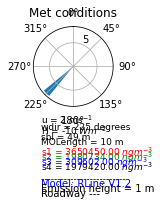

In [25]:
for h in dfm['Hour'].unique():
    temp = 'dfm_{}'.format(h)    
    vars()[temp] = dfm[dfm['Hour']==h]
plot_met_data(dfm_1, sites)
#----------------------------------------------------------------------

<img style="float: center;" src="urban_rural_scape.png" alt="urban" width="1100px"/>

In [ ]:
# which OS is this running on?
platform = get_platform()
# use Pandas to read in emissions data
dfe=pd.read_csv("Output_Example_Numerical_09-12.csv", header=10, skipinitialspace=True)

# lets have a look at the first 5 rows of data
dfe.head(5)
#extract_hourly_data(dfe,1)

In [ ]:
# use Pandas to read in meteorology data
dfm=pd.read_csv("Met_Example.csv", skip_blank_lines=True, skipinitialspace=True)
#dfm.set_index('Year')
# lets have a look at the first 5 rows of data
dfm.head(5)

In [ ]:
# Find max,min so we can set appropriate contour intervals
max = dfe['C_G1'].max()
min = dfe['C_G1'].min()
print(min,max) 
#print(datam)    
#extract_hourly_data()

# END